In [68]:
# neo4j, langchain, langchain-community, python-dotenv, openai, matplotlib

In [58]:
from openai import OpenAI
from dotenv import load_dotenv
import os
import time

from langchain.graphs import Neo4jGraph

In [22]:
load_dotenv(dotenv_path = "secrets.env")
client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
graph = Neo4jGraph(
    url=os.environ["NEO4J_URI"],
    username=os.environ["NEO4J_USERNAME"],
    password=os.environ["NEO4J_PASSWORD"]
)

In [38]:
def create_word_node(word):
    query = """
    MERGE (w:Word {text: $word})
    ON CREATE SET w.frequency = 1
    ON MATCH SET w.frequency = w.frequency + 1
    RETURN w
    """
    result = graph.query(query, {"word": word})
    return result

# Example usage:
created_node = create_word_node("example")
created_node = create_word_node("connection")
print(f"Created node: {created_node}")

Created node: [{'w': {'text': 'connection', 'frequency': 1}}]


In [41]:
def create_edge_between_words(word1, word2):
    query = """
    MATCH (w1:Word {text: $word1})
    MATCH (w2:Word {text: $word2})
    MERGE (w1)-[r:FOLLOWED_BY]->(w2)
    ON CREATE SET r.frequency = 1
    ON MATCH SET r.frequency = r.frequency + 1
    RETURN r
    """
    result = graph.query(query, {"word1": word1, "word2": word2})
    return result

# Example usage:
word1 = "example"
word2 = "connection"
created_edge = create_edge_between_words(word1, word2)
print(f"Created edge: {created_edge}")


Created edge: []


In [57]:
def delete_all_edges_and_nodes():
    delete_edges_query = """
    MATCH ()-[r]->()
    DELETE r
    """
    delete_nodes_query = """
    MATCH (n)
    DELETE n
    """
    
    # Delete all edges first
    graph.query(delete_edges_query)
    
    # Then delete all nodes
    result = graph.query(delete_nodes_query)
    
    return result

# Execute the function to delete all edges and nodes
deletion_result = delete_all_edges_and_nodes()
print("All edges and nodes have been deleted from the graph.")


All edges and nodes have been deleted from the graph.


In [59]:
def user_input_loop():
    while True:
        user_input = input("Enter your query (or '/quit' to exit): ")
        if user_input.lower() == '/quit':
            print("Exiting the program. Goodbye!")
            break
        else:
            print(f"You entered: {user_input}")
            delimiters = [':', '.', ';', '?', '!', ',', ' ']
            split_input = [user_input.lower()]
            for delimiter in delimiters:
                split_input = [part for item in split_input for part in item.split(delimiter) if part]
            
            if len(split_input) > 0:
                total_words = len(split_input)
                print(f"Processing {total_words} words...")
                create_word_node(split_input[0])
                i = 1
                progress_interval = max(1, total_words // 400)  # Print progress every 0.25% or for each word if less than 10
                start_time = time.time()
                while i < len(split_input):
                    create_word_node(split_input[i])
                    create_edge_between_words(split_input[i-1], split_input[i])
                    if i % progress_interval == 0 or i == total_words - 1:
                        elapsed_time = time.time() - start_time
                        progress_percentage = (i + 1) / total_words * 100
                        words_per_second = (i + 1) / elapsed_time
                        estimated_total_time = total_words / words_per_second
                        estimated_remaining_time = estimated_total_time - elapsed_time
                        print(f"Progress: {i+1}/{total_words} words processed ({progress_percentage:.2f}%)")
                        print(f"Estimated completion rate: {words_per_second:.2f} words/second")
                        print(f"Estimated time remaining: {estimated_remaining_time:.2f} seconds")
                    i += 1
                total_time = time.time() - start_time
                print(f"Processing complete. Total time: {total_time:.2f} seconds")


user_input_loop()


You entered: Scripts.com Bee Movie By Jerry Seinfeld  NARRATOR: (Black screen with text; The sound of buzzing bees can be heard) According to all known laws of aviation,  : there is no way a bee should be able to fly.  : Its wings are too small to get its fat little body off the ground.  : The bee, of course, flies anyway  : because bees don't care what humans think is impossible. BARRY BENSON: (Barry is picking out a shirt) Yellow, black. Yellow, black. Yellow, black. Yellow, black.  : Ooh, black and yellow! Let's shake it up a little. JANET BENSON: Barry! Breakfast is ready! BARRY: Coming!  : Hang on a second. (Barry uses his antenna like a phone)  : Hello? ADAM FLAYMAN:  (Through phone) - Barry? BARRY: - Adam? ADAM: - Can you believe this is happening? BARRY: - I can't. I'll pick you up. (Barry flies down the stairs)  : MARTIN BENSON: Looking sharp. JANET: Use the stairs. Your father paid good money for those. BARRY: Sorry. I'm excited. MARTIN: Here's the graduate. We're very proud 

KeyboardInterrupt: 

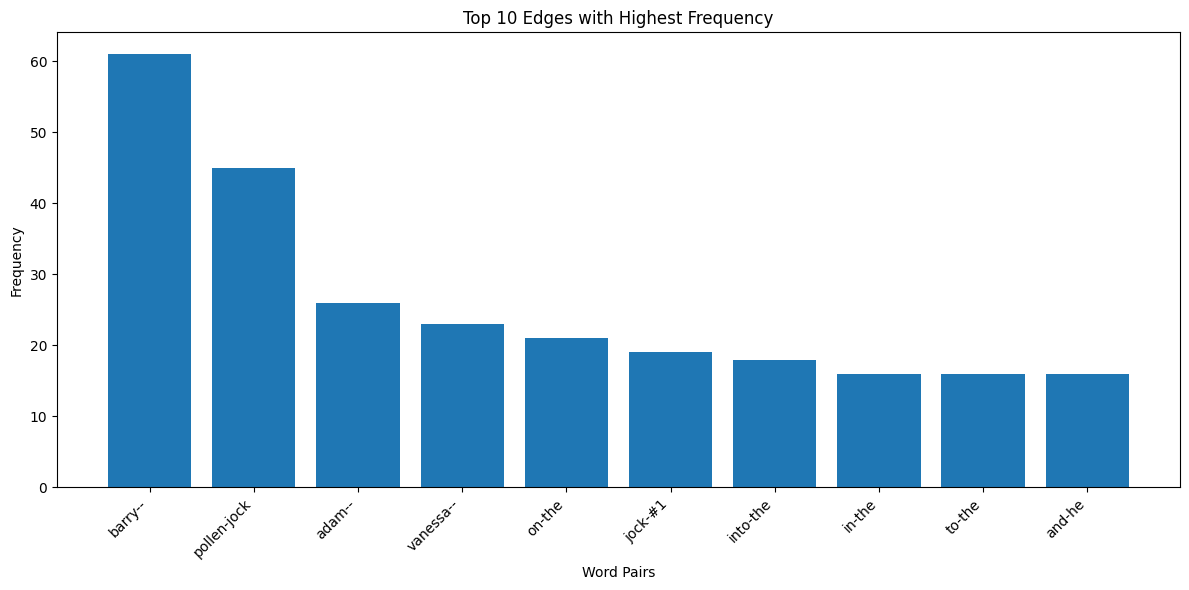

In [72]:
import matplotlib.pyplot as plt

def get_topK_edges():
    query = """
    MATCH (n1)-[r]->(n2)
    RETURN n1.text AS word1, n2.text AS word2, r.frequency AS frequency
    ORDER BY r.frequency DESC
    LIMIT 10
    """
    results = graph.query(query)
    
    word_pairs = []
    frequencies = []
    
    for result in results:
        word1 = result.get('word1', 'N/A')
        word2 = result.get('word2', 'N/A')
        frequency = result.get('frequency', 0)
        word_pairs.append(f"{word1}-{word2}")
        frequencies.append(frequency)
    
    plt.figure(figsize=(12, 6))
    plt.bar(word_pairs, frequencies)
    plt.title("Top 10 Edges with Highest Frequency")
    plt.xlabel("Word Pairs")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

get_topK_edges()


In [ ]:
SYSTEM_QUERY_DEFAULT = ["You are a highly intelligent general agent capable of responding to any query."]
def vanilla_gpt_query(user_messages: list[str] = [], system_messages: list[str] = SYSTEM_QUERY_DEFAULT):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {'role': 'system', 'content': '\n'.join(system_messages)},
            {'role': 'user', 'content': '\n'.join(user_messages)}
        ]
    )
    return response.choices[0].message.content

In [ ]:
graph = Neo4jGraph(
    url=os.environ["NEO4J_URI"],
    username=os.environ["NEO4J_USERNAME"],
    password=os.environ["NEO4J_PASSWORD"]
)